# Model-free Reinforcement Learning

Assume that we have the same grid world as in the previous tutorial:

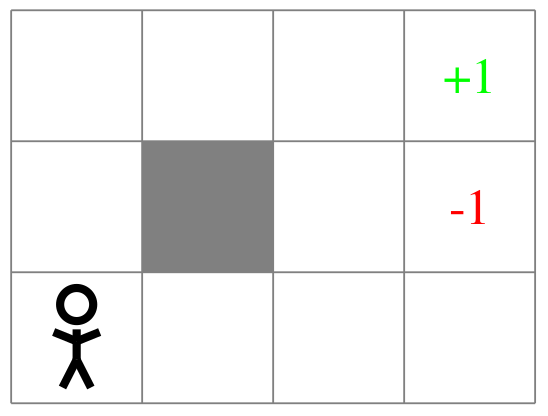

The goal of the agent whose position is at the bottom left corner is to maximize the expected future reward.
The top right (reward +1) and the middle right cell (reward -1) are terminal states.
There are four different actions the agent can choose, namely go up, down, left and right.
However, there is a chance that the agent will result in a wrong grid cell by accident.
If the action is going up, there is a chance of 0.8 that the agent moves up, a chance of 0.1 that he moves left and a chance of 0.1 that he moves right.
All other actions behave accordingly.
If the agent would bounce on a wall it stays at the current position.
Note that the agent cannot move through the grayed-out grid cell.
Assume a gamma value of $\gamma=0.9$.


### Environment Definition:

As we use model-free reinforcement learning, we do not actually have access to he MDP itself.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
class MDP:
    
    "0: up, 1: right, 2: left, 3: down"
    _transitions = np.array([
        [[4, 0.8], [-1, 0.1], [1, 0.1]],
        [[1, 0.8], [-4, 0.1], [4, 0.1]],
        [[-1, 0.8], [-4, 0.1], [4, 0.1]],
        [[-4, 0.8], [-1, 0.1], [1, 0.1]]
        ])
    
    def __init__(self, gamma=0.9):
        self.reward = np.zeros(3*4)
        self.reward[-1] = +1
        self.reward[5] = -1
        self.reward[7] = -1
        self.gamma = gamma
        
    def rewards(self, state):
        """
        Returns the reward for the given state as scalar.
        """
        return self.reward[state]
    
    def _bounces(self, state, s):
        return np.sum(
            np.abs(np.array(np.where(np.arange(12).reshape((3,4)) == state)) 
                   - np.array(np.where(np.arange(12).reshape((3,4)) == s)))
        ) > 1
    
    def transition(self, state, action):
        """
        Returns a list of follow states including their probabilities.
        If a state has zero probability, it will be skipped.
        Example:
        Suppose we have state action pair where we have two follow states 
        (4 and 6) with probability 0.4 and 0.6 respectively (all other states have 0 probability) our result ist:
        [[4, 0.4], [6, 0.6]]
        """
        if state == 7 or state == 11:
            return np.zeros((0,2))
        trans = MDP._transitions[action].copy()
        trans = trans.T
        trans[0,:] += state
        trans = trans.T
        for i, (s, prob) in enumerate(trans):
            if s < 0 or s >= 3*4 or s == 5 or self._bounces(state, s):
                trans[i,0] = state
        return trans

In [3]:
def print_state_values(utilities):
    plt.figure()
    reshaped = utilities.reshape((3,4))
    reshaped[1,1] = np.nan
    ax = sns.heatmap(reshaped, annot=True)
    ax.invert_yaxis()

## Model-free

This time, we assume that the agent does not have any information about the model.
It can only learn by experience (observations and rewards) from the environment.
In the following cell we define the environment the agent interacts with:

In [4]:
class GridEnvironment:
    
    def __init__(self):
        self.mdp = MDP()
        self.reset()
    
    def reset(self):
        self.state = 0
        return self.state
    
    def act(self, action):
        trans = self.mdp.transition(self.state, action)
        if len(trans) > 0:
            self.state = int(np.random.choice(trans[:,0], p=trans[:,1]))
        else:
            raise Exception("terminal state has no action!")
        reward = self.mdp.rewards(self.state)
        done = self.state == 7 or self.state == 11
        return self.state, reward, done
    
    def actions(self):
        return range(4)

# Q-Learning

Complete the Q-Learning algorithm in the following cell:

In [5]:
def eps_greedy(qs, epsilon):
    # choose greedy action (exploitation)
    action = np.argmax(qs)

    # epsilon greedy (exploration)
    if np.random.random() <= epsilon:
        action = np.random.randint(len(env.actions()))
    
    return action

def q_learning(env, alpha, gamma, epsilon, epochs):
        
    q_table = {}
    
    for epoch in range(epochs):
        
        done = False
        observation = env.reset()
        
        while not done:
            qs = q_table.get(observation, np.zeros(len(env.actions())))
            action = eps_greedy(qs, epsilon)
            next_obs, reward, done = env.act(action)

            # update q table
            next_qs = q_table.get(next_obs, np.zeros(len(env.actions())))
            qs[action] = (1-alpha) * qs[action] + alpha * (reward + gamma * np.max(next_qs))
            
            q_table[observation] = qs
            observation = next_obs
        
    return q_table

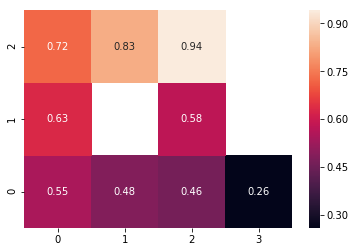

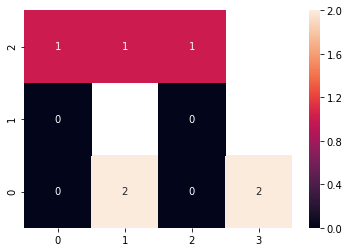

In [6]:
env = GridEnvironment()

q_table = q_learning(env, 0.01, 0.9, 0.5, 20000)

# note that we do not have any action to choose in the terminal states and 
# thus we do not have any q-values for terminal states
utilities = np.asarray([np.max(q_table.get(i, [np.nan])) for i in range(12)])
print_state_values(utilities)

policy = np.asarray([np.nan if i not in q_table else np.argmax(q_table[i]) for i in range(12)])
print_state_values(policy)

From the previous lecture we know that the optimal utility is:

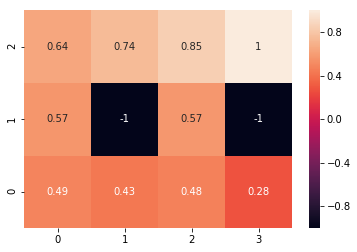

The optimal policy is:

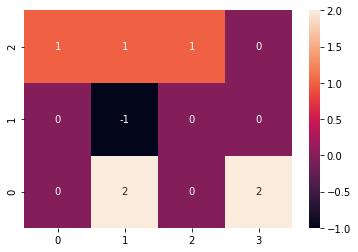

## SARSA

Complete the SARSA algorithm in the following cell:

In [7]:
def sarsa(env, alpha, gamma, epsilon, epochs):
        
    q_table = {}
    
    for epoch in range(epochs):
        
        done = False
        observation = env.reset()
        action = None
        
        while not done:
            qs = q_table.get(observation, np.zeros(len(env.actions())))
            q_table[observation] = qs
            if action is None:
                action = eps_greedy(qs, epsilon)
            next_obs, reward, done = env.act(action)
            
            # choose next epsilon greedy action
            next_qs = q_table.get(next_obs, np.zeros(len(env.actions())))
            next_action = eps_greedy(next_qs, epsilon)

            # update q table
            qs[action] = (1-alpha) * qs[action] + alpha * (reward + gamma * next_qs[next_action])
            
            observation = next_obs
            action = next_action
        
    return q_table

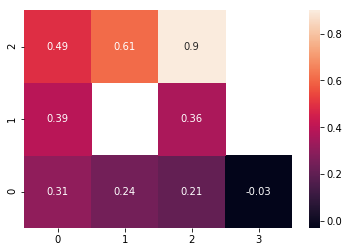

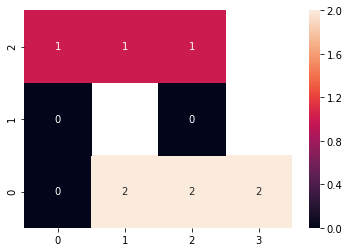

In [8]:
env = GridEnvironment()

q_table = sarsa(env, 0.01, 0.9, 0.5, 20000)

# note that we do not have any action to choose in the terminal states and 
# thus we do not have any q-values for terminal states
utilities = np.asarray([np.max(q_table.get(i, [np.nan])) for i in range(12)])
print_state_values(utilities)

policy = np.asarray([np.nan if i not in q_table else np.argmax(q_table[i]) for i in range(12)])
print_state_values(policy)

## Question

Why is the policy from SARSA different? Is it optimal?
What do we need to change such that the policies are equal?

### Solution:
SARSA computes the q-values with respect to the $\epsilon$-greedy policy.
This means that with probabiliy $\epsilon$ the policy is doing something random and thus SARSA assumes that the probability is higher to enter the bad state when it is close to it.
SARSA's policy is thus pessimistic.

Q-Learning is off-policy and thus it optimizes the greedy policy while acting with the $\epsilon$-greedy policy. The agent acts thus more risky as it assumes that entering the bad state is much less probable than it actually is with the $\epsilon$-greedy policy (behaviour policy).

When we decay the epsilon over time, such that epsilon is equal to zero at the last epoch, SARSA converges to the optimal greedy policy as well and thus the policies will be equal.